In [3]:
import Bio
from Bio import SeqIO
import gzip
from glob import glob
import re

In [2]:
ls

'Cell free RNA asasy - MT.xlsx'      S10_S111_L008_R1_001.fastq.gz
'Diabetic and Controls cfRNA.xlsx'   S10_S111_L008_R2_001.fastq.gz
 process_exoRNA-seq.ipynb            S11_S112_L008_I1_001.fastq.gz
 readme.txt                          S11_S112_L008_R1_001.fastq.gz
 S01_S102_L008_I1_001.fastq.gz       S11_S112_L008_R2_001.fastq.gz
 S01_S102_L008_R1_001.fastq.gz       S12_S113_L008_I1_001.fastq.gz
 S01_S102_L008_R2_001.fastq.gz       S12_S113_L008_R1_001.fastq.gz
 S02_S103_L008_I1_001.fastq.gz       S12_S113_L008_R2_001.fastq.gz
 S02_S103_L008_R1_001.fastq.gz       S13_S114_L008_I1_001.fastq.gz
 S02_S103_L008_R2_001.fastq.gz       S13_S114_L008_R1_001.fastq.gz
 S03_S104_L008_I1_001.fastq.gz       S13_S114_L008_R2_001.fastq.gz
 S03_S104_L008_R1_001.fastq.gz       S14_S115_L008_I1_001.fastq.gz
 S03_S104_L008_R2_001.fastq.gz       S14_S115_L008_R1_001.fastq.gz
 S04_S105_L008_I1_001.fastq.gz       S14_S115_L008_R2_001.fastq.gz
 S04_S105_L008_R1_001.fastq.gz       S15_S116_L008_I1_001.fast

In [8]:
###Example
files = glob('*_R1_001.fastq.gz')
for f1 in files:
    R1 = gzip.open(f1, "rt")
    R2 = gzip.open(re.sub("_R1_001.fastq.gz", "_R2_001.fastq.gz", f1), "rt")
    out = gzip.open(re.sub("_S\\d+_L008_R1_001.fastq.gz", ".fastq.gz", f1), "wt")
    print(re.sub("_S\\d+_L008_R1_001.fastq.gz", ".fastq.gz", f1))
    
    fq1 = SeqIO.parse(R1, "fastq")
    fq2 = SeqIO.parse(R2, "fastq")
    for (r1, r2) in zip(fq1, fq2):
        if r1.name != r2.name:
            print("ALERT")
        name = str(r1.name)
        umi = str(r2.seq)
        r1.description = name+'_'+umi
        r1.name = name+'_'+umi
        r1.id = name+'_'+umi
        out.write(r1.format("fastq"))

    R1.close()
    R2.close()
    out.close()

S12.fastq.gz


In [9]:
%%bash
nohup sh -c "ls *_R1_001.fastq.gz | parallel -j24 -k python append_umi.py {}" &

In [ ]:
%%bash
shopt -s extglob
for f in S??.fastq.gz; do
out=${f/.fastq.gz/.trim.fastq.gz}
echo "cutadapt -j 12 -m 15 -u 3 -a AAAAAAAAAAAAAAAA -o $out $f;"
cutadapt -j 12 -m 15 -u 3 -a AAAAAAAAAAAAAAAA -o $out $f;
done

In [ ]:
%%bash
for f in *.trim.fastq.gz; do
out=${f/.trim.fastq.gz/.bam}
echo "bowtie2 --sensitive --end-to-end -N 1 -p 24 -x /avicenna/genomes/hg38/hg38 -U $f | samtools view - -Sb  -h -t /avicenna/genomes/hg38/hg38.fa.fai -o $out";
bowtie2 --sensitive --end-to-end -N 1 -p 12 -x /avicenna/genomes/hg38/hg38 -U $f | samtools view - -Sb  -h -t /avicenna/genomes/hg38/hg38.fa.fai -o $out ;
done

In [ ]:
%%bash
for f in *.bam; do
out=${f/.bam/.srt.bam};
echo "samtools sort -o $out $f";
samtools sort -@ 4 -m 2G -o $out $f
samtools index $out;
done

In [ ]:
%%bash
for f in *.srt.bam; do
out=${f/.srt.bam/.srt.dd.bam};
echo "umi_tools dedup -I $f -S $out";
umi_tools dedup -I $f -S $out &
done

## Annotated genes

In [ ]:
#%%bash
#for f in *.srt.dd.bam; do
#out=${f/.srt.dd.bam/.fc};
#echo "featureCounts -T 12 -O -t exon -g gene_id -a /avicenna/genomes/hg38/hg38_genes.gtf -o $out $f";
#featureCounts -T 12 -O -M --fraction -t exon -g gene_id -a /avicenna/genomes/hg38/hg38_genes.gtf -o $out $f
#done

In [ ]:
%%bash
for f in *.srt.dd.bam; do
out=${f/.srt.dd.bam/.srt.dd.fastq}
echo "bamToFastq -i $f -fq $out"
bamToFastq -i $f -fq $out
done

In [130]:
%%bash
for f in *.srt.dd.fastq; do
gzip $f &
done

In [ ]:
%%bash
for f in *.srt.dd.fastq.gz; do
out=${f/.srt.dd.fastq.gz/_salmon}
echo "salmon quant --validateMappings -i /avicenna/genomes/hg38/gencode.v28.transcripts.salmon.index -l SF -r $f -p 12 -o $out";
salmon quant --validateMappings -i /avicenna/genomes/hg38/gencode.v28.transcripts.salmon.index -l SF -r $f -p 12 -o $out
done

In [2]:
import rpy2.ipython
%load_ext rpy2.ipython
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [18]:
%%R -o info
library(readxl)
info <- as.data.frame(read_excel('Diabetic\ and\ Controls\ cfRNA.xlsx'))
info


   Coded # Sample Number Control/T1D Age Years Gender
1        1          70.7     Control        11      M
2        2         103.0         T1D        15      F
3        3          63.0         T1D         5      F
4        4          43.0     Control         9      F
5        5          91.0         T1D        10      F
6        6          75.0         T1D        13      M
7        7          70.6     Control         6      F
8        8          70.2     Control         8      M
9        9          70.5     Control         4      F
10      10          45.0         T1D         9      F
11      11          50.0     Control        14      F
12      12          70.4     Control         7      F
13      13         107.0         T1D         3      F
14      14          70.3     Control        13      M
15      15          41.0         T1D         8      M
16      16          42.0     Control         6      F
17      17          33.0         T1D         6      F
18      18          51.0    

In [138]:
%%bash
#not a good run, drop from analysis
rm -r S15_salmon

In [143]:
%%R -i info
info[-15,]

   Coded.. Sample.Number Control.T1D Age.Years Gender
0        1          70.7     Control        11      M
1        2         103.0         T1D        15      F
2        3          63.0         T1D         5      F
3        4          43.0     Control         9      F
4        5          91.0         T1D        10      F
5        6          75.0         T1D        13      M
6        7          70.6     Control         6      F
7        8          70.2     Control         8      M
8        9          70.5     Control         4      F
9       10          45.0         T1D         9      F
10      11          50.0     Control        14      F
11      12          70.4     Control         7      F
12      13         107.0         T1D         3      F
13      14          70.3     Control        13      M
15      16          42.0     Control         6      F
16      17          33.0         T1D         6      F
17      18          51.0     Control        10      F
18      19          78.0    

In [145]:
%%R -i info -o res
files <- list.files(pattern="quant.sf",full.names = TRUE, recursive=T)
library(tximport)
library(readr)
tx2gene <- read_tsv("/avicenna/genomes/hg38/gencode.v28.tx2gene.cvs")
head(tx2gene)

names(files) <- gsub("./(\\S+)_quant/quant.sf","\\1",files)
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

write.table(txi$abundance, "tx_abudance_salmon.txt", sep="\t", quote=FALSE, col.names=NA )
write.table(txi$counts, "tx_ncount_salmon.txt", sep="\t", quote=FALSE, col.names=NA )

txi.gene <- summarizeToGene(txi, tx2gene)
head(txi.gene$counts)
write.table(txi.gene$abundance, "gene_abudance_salmon.txt", sep="\t", quote=FALSE, col.names=NA )
write.table(txi.gene$counts, "gene_ncount_salmon.txt", sep="\t", quote=FALSE, col.names=NA )

library(DESeq2)
info <- info[-15,]
cond <- factor(info[,3])
age <- info[,4]
gender <- info[,5]
colData <- data.frame(cond, age, gender, row.names=colnames(txi$abundance))
dds <- DESeqDataSetFromTximport(txi, colData = colData, design = ~ cond+age+gender)
dds$cond<- relevel(dds$cond, ref="Control")
dds <- DESeq(dds)
res <- as.data.frame(results(dds, contrast=list("cond_T1D_vs_Control"), tidy=TRUE))
ncu <- counts(dds, normalized=TRUE)
write.table(res, "T1D_vs_Control_tx_DE2_logFC.txt", sep="\t", quote=FALSE, col.names=NA )
resultsNames(dds)

[1] "Intercept"           "cond_T1D_vs_Control" "age"                
[4] "gender_M_vs_F"      


In [3]:
%%R -o res,ids
library(biomaRt)
mart <- useMart(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
res <- read.table("T1D_vs_Control_tx_DE2_logFC.txt", sep="\t", header=T, row.names=1 )
res <- res[!is.na(res$padj),]
transcript_ids <- res$row
ids <- getBM(attributes = c('ensembl_transcript_id_version', 
                            'ensembl_gene_id', 
                            'external_gene_name'),
             filters = 'ensembl_transcript_id_version', 
             values = transcript_ids,
             mart = mart)
head(ids)


  ensembl_transcript_id_version ensembl_gene_id external_gene_name
1             ENST00000383893.1 ENSG00000206620           SNORD45C
2             ENST00000516993.1 ENSG00000252802         AL627313.2
3             ENST00000384052.1 ENSG00000206779         CR589951.1
4             ENST00000613387.1 ENSG00000276493         AL445248.2
5             ENST00000488127.1 ENSG00000157978            LDLRAP1
6             ENST00000374332.8 ENSG00000117643             MAN1C1


/avicenna/hani/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [7]:
%%R -i res,ids -o res
res <- merge(res, ids, by.x="row", by.y="ensembl_transcript_id_version")
write.table(res, "T1D_vs_Control_tx_DE2_logFC.txt", sep="\t", quote=FALSE, row.names=F)

In [8]:
%%bash
head T1D_vs_Control_tx_DE2_logFC.txt

row	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj	ensembl_gene_id	external_gene_name
ENST00000003912.7	1.86554533285454	0.308380885130154	0.776975538905301	0.396899091012105	0.69144187453832	0.945506611280156	ENSG00000001461	NIPAL3
ENST00000008876.7	5.41368687249663	-0.0644370399959646	0.413667178439031	-0.155770250468305	0.876214121025175	0.98271112225152	ENSG00000008735	MAPK8IP2
ENST00000014914.5	12.1834040588719	-0.936435621095603	0.725002364497093	-1.29163112694836	0.196484919153289	0.799999372030176	ENSG00000013588	GPRC5A
ENST00000173785.4	2.87950692618974	-0.18897830296703	1.8501217597214	-0.102143711339024	0.918642605801527	0.988323034840686	ENSG00000067082	KLF6
ENST00000202773.13	13.2731761399895	0.257367237576691	0.636845076333766	0.40412848766661	0.686118237339732	0.944220288909681	ENSG00000089009	RPL6
ENST00000202816.5	0.843343054782354	0.723265484057829	1.81366989003191	0.39878562688445	0.690051168545395	0.945253393158049	ENSG00000089048	ESF1
ENST00000211998.9	2.0555354524

In [11]:
%%R -i res
sig <- res[res$padj<0.25 & res$log2FoldChange>0,]
head(sig)

                  row  baseMean log2FoldChange     lfcSE     stat       pvalue
787 ENST00000362607.1  11.00723       3.183433 0.7877816 4.041010 5.322147e-05
791 ENST00000362704.1   3.66892       3.620526 0.9107672 3.975249 7.030570e-05
792 ENST00000362761.1  43.01379       4.655582 0.9277901 5.017926 5.223238e-07
798 ENST00000362883.1  86.03775       2.260901 0.6115577 3.696954 2.182015e-04
804 ENST00000363046.1 143.30681       8.169576 2.5845380 3.160942 1.572596e-03
805 ENST00000363091.1  31.79929       2.902030 0.7195422 4.033162 5.503141e-05
            padj ensembl_gene_id external_gene_name
787 0.0155207161 ENSG00000199477            SNORA31
791 0.0176543113 ENSG00000199574           SNORD18C
792 0.0007575188 ENSG00000199631            SNORD33
798 0.0340797191 ENSG00000199753           SNORD104
804 0.1438287444 ENSG00000277027               RMRP
805 0.0155207161 ENSG00000199961            SNORD1B


In [14]:
%%R -i res -o gene.list
library(readxl)
s <- as.data.frame(read_excel('Cell\ free\ RNA\ asasy\ -\ MT.xlsx'))
gene.list <- s$Genes
head(gene.list)


[1] "CD38"  "CPE"   "TOP2A" "TOP2B" "GAD2"  "GAD1" 


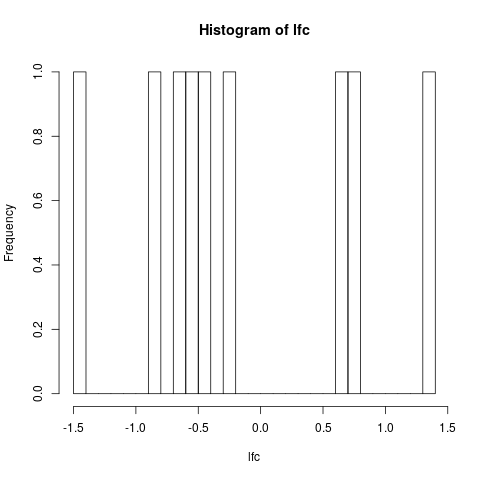

In [16]:
%%R -i res,gene.list
lfc <- res[res$external_gene_name %in% gene.list,"log2FoldChange"]
hist(lfc, na.rm=T, breaks=20)

png 
  2 


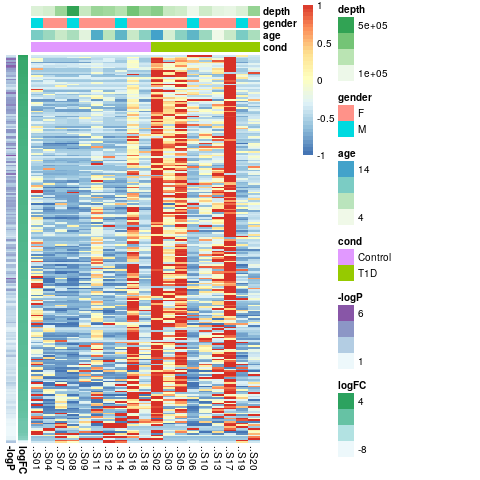

In [45]:
%%R -i info
library(pheatmap)
library(RColorBrewer)

res <- read.table("T1D_vs_Control_tx_DE2_logFC.txt", sep="\t", header=T, row.names=1, stringsAsFactors=FALSE)
ncu <- read.table("tx_abudance_salmon.txt", sep="\t", header=T, row.names=1 )
m <- read.table("tx_ncount_salmon.txt", sep="\t", header=T, row.names=1 )
res <- res[!is.na(res$padj),]
ncu <- ncu[rownames(res),]
ncu.sno <- ncu[startsWith(res$external_gene_name, "SNOR"),]
info <- info[-15,]
cond <- factor(info[,3])
age <- info[,4]
gender <- info[,5]
depth <- colSums(m)
colData <- data.frame(cond, age, gender, depth, row.names=colnames(ncu))
colData <- colData[order(colData$cond),]

ncu.sno <- ncu.sno[,rownames(colData)]
res.sno <- res
res.sno <- res.sno[rownames(ncu.sno),c("log2FoldChange", "pvalue")]
res.sno <- res.sno[order(res.sno$log2FoldChange,decreasing = T),]
res.sno$pvalue <- -log10(res.sno$pvalue)
colnames(res.sno) <- c("logFC", "-logP")
ncu.sno <- ncu.sno[rownames(res.sno),]
ncu.sno.norm <- t(scale(t(ncu.sno)))
colnames(ncu.sno.norm) <- gsub("_salmon.quant.sf", "", colnames(ncu.sno.norm))

breaksList = seq(-1, 1, by = 0.05)
x <- pheatmap(ncu.sno.norm, scale="row", annotation_col=colData,annotation_row=res.sno, cluster_cols=F, cluster_rows=F, labels_row="", 
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), breaks=breaksList)
pdf("snoRNAs_heatmap.pdf")
grid::grid.newpage()
grid::grid.draw(x$gtable)
dev.off()



png 
  2 


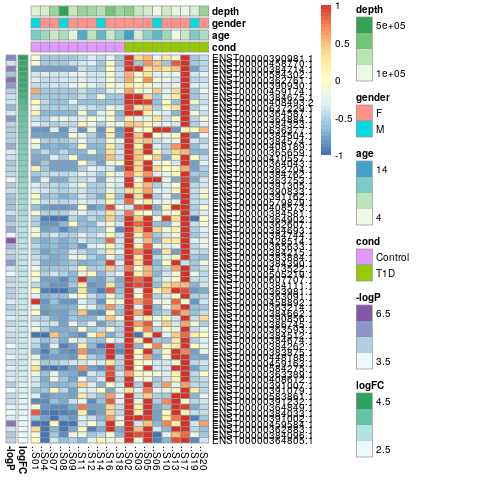

In [54]:
%%R -i info
library(pheatmap)
library(RColorBrewer)

res <- read.table("T1D_vs_Control_tx_DE2_logFC.txt", sep="\t", header=T, row.names=1, stringsAsFactors=FALSE)
ncu <- read.table("tx_abudance_salmon.txt", sep="\t", header=T, row.names=1 )
m <- read.table("tx_ncount_salmon.txt", sep="\t", header=T, row.names=1 )
res <- res[!is.na(res$padj),]
res <- res[res$padj<0.1 & res$log2FoldChange>0,]
ncu <- ncu[rownames(res),]
ncu.sno <- ncu[startsWith(res$external_gene_name, "SNOR"),]
info <- info[-15,]
cond <- factor(info[,3])
age <- info[,4]
gender <- info[,5]
depth <- colSums(m)
colData <- data.frame(cond, age, gender, depth, row.names=colnames(ncu))
colData <- colData[order(colData$cond),]

ncu.sno <- ncu.sno[,rownames(colData)]
res.sno <- res
res.sno <- res.sno[rownames(ncu.sno),c("log2FoldChange", "pvalue")]
res.sno <- res.sno[order(res.sno$log2FoldChange,decreasing = T),]
res.sno$pvalue <- -log10(res.sno$pvalue)
colnames(res.sno) <- c("logFC", "-logP")
ncu.sno <- ncu.sno[rownames(res.sno),]
ncu.sno.norm <- t(scale(t(ncu.sno)))
colnames(ncu.sno.norm) <- gsub("_salmon.quant.sf", "", colnames(ncu.sno.norm))

breaksList = seq(-1, 1, by = 0.05)
x <- pheatmap(ncu.sno.norm, scale="row", annotation_col=colData,annotation_row=res.sno, cluster_cols=F, cluster_rows=F, 
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), breaks=breaksList)
pdf("snoRNAs_sig_heatmap.pdf")
grid::grid.newpage()
grid::grid.draw(x$gtable)
dev.off()



# T1D Analysis 

In [1]:
import pandas as pd
import numpy as np
import os
import re
import xlsxwriter
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("S01_data.csv",usecols=["seq","strand"])
data["S01"] = 1
for x in range(2, 21):
    if x < 10:
        new_col = pd.read_csv(f"S0{x}_data.csv", usecols = ["seq","strand"])
        new_col[f"S0{x}"] = 1
    elif x == 15:
        continue
    else:
        new_col = pd.read_csv(f"S{x}_data.csv", usecols = ["seq","strand"])
        new_col[f"S{x}"] = 1
    data = data.merge(new_col, on=["seq","strand"], how="outer")

In [3]:
data = data.fillna(0)

In [4]:
data.head(5)

,seq,strand,S01,S02,S03,S04,S05,S06,S07,S08,...,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
0,GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCG,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,GCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTAG,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,CGCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTA,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,CTTTGGGTTCCGGGGGGAGTATGGTTGCAAAGCTG,+,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
path = "Diabetic and Controls cfRNA.xlsx"
meta = pd.read_excel(path, sheet_name=None)
meta_data = meta["Samples 1 "]
meta_data = meta_data.drop(14)
meta_data

,Coded #,Sample Number,Control/T1D,Age Years,Gender
0,1,70.7,Control,11,M
1,2,103.0,T1D,15,F
2,3,63.0,T1D,5,F
3,4,43.0,Control,9,F
4,5,91.0,T1D,10,F
5,6,75.0,T1D,13,M
6,7,70.6,Control,6,F
7,8,70.2,Control,8,M
8,9,70.5,Control,4,F
9,10,45.0,T1D,9,F


In [6]:
data = data.set_index(["seq","strand"])

In [7]:
data.shape

(9878576, 19)

In [8]:
arrays = [list(meta_data["Control/T1D"]), list(data.columns)]
tuples = list(zip(*arrays))
control = [x[1] for x in tuples if x[0] == "Control"]
t1d = [x[1] for x in tuples if x[0] == "T1D"]

## Filter RNA species
Filter out all RNA species that are present in only one of the samples and all RNA species that are present in 3 or more control samples. 

In [11]:
def filter_ones_and_ctrl(row):
    count = 0
    for ctrl in control:
        count += row[ctrl]
    return count < 3 and np.sum(row) > 1

In [12]:
filter_data = data[data.apply(filter_ones_and_ctrl, axis=1)]

In [13]:
filter_data.shape

(1234458, 19)

In [14]:
filter_data.head(5)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
CTATGAGTGACTACAAAAAGGATTAGACTGAGCTG,+,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
GGATTTTTGGAGCAGGGAGAT,-,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGAAGAAAACCTATGG,-,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GAAAAAAAAAAAAGAGAAAG,-,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
GATTTTTGGAGCAGG,-,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


After passing the data through the two filters, we reduce the number of RNA species from 9878576 to 1234458. 

## Fisher's Exact Test and Visualizations
Fisher's Exact Test (one-sided)
<br/>Table from each row of data:
<pre>   [Diabetes Presence, Control Presence] 
   [Diabetes Absence, Control Absence]</pre>
S15 is excluded. Greater alternative hypothesis using scipy.stats.fisher_exact. 9 T1D samples and 10 control samples.

In [20]:
def fisher(row):
    ctrl_pres = 0
    t1d_pres = 0
    for ctrl in control:
        ctrl_pres += row[ctrl]
    for t in t1d:
        t1d_pres += row[t]
    oddsratio, pvalue = stats.fisher_exact([[t1d_pres, ctrl_pres], 
                                [9-t1d_pres, 10-ctrl_pres]], "greater")
    return pvalue


In [21]:
pvals = filter_data.apply(fisher,axis=1)

In [22]:
filter_data["pval"] = pvals

/avicenna/jwang/anaconda3/envs/smRNA/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
sig_data = filter_data[filter_data["pval"] <= 0.05]
sig_data.shape

(2628, 20)

In [24]:
sig_hmdata = sig_data.iloc[:,:19]
sig_hmdata.head(10)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
CACACACACACACACACAC,+,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
AGAAAGAGAGAGAGAAAGAAAAAAGAAAGAAAGAAAGAAAGAAAGAA,+,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
CAACAGAGCGAGACTCTTTCTC,+,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
GCGAAAGAGAGAGAAAAGGAGAGGAGAGAAGCGAGAGAGAG,-,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
GGGGGTGTGGGGAAAAAAAG,+,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CACCGCCCGTCGCTACTACCGAT,+,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
CCGACCCGGGGAGGTAGTGAC,+,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
TGACAAGAGTGAAACTCTGTCTC,-,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ACAGAGTGAGACTCCATCTC,-,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
sample_index = pd.MultiIndex.from_tuples(tuples)
indexed_sig_hmdata = pd.DataFrame(sig_hmdata.values, index=sig_hmdata.index, 
                                  columns=sample_index).sort_index(axis=1)

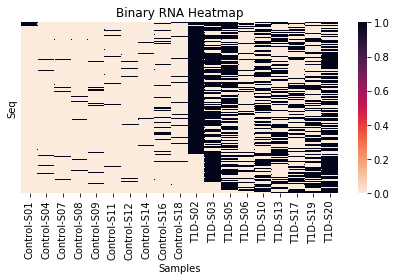

In [27]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(indexed_sig_hmdata,yticklabels=False, vmin=0, vmax=1, cmap=cmap)
plt.xlabel("Samples")
plt.ylabel("Seq")
plt.title("Binary RNA Heatmap")
plt.tight_layout()
plt.savefig("Binary_RNA_heatmap.png");

In [36]:
countdata = pd.read_csv("S01_data.csv",usecols=["seq", "count","strand",])
countdata.columns = ["seq", "S01", "strand"]
for x in range(2, 21):
    if x < 10:
        new_col = pd.read_csv(f"S0{x}_data.csv", usecols = ["seq", "count","strand"])
        new_col.columns = ["seq", f"S0{x}","strand"]
    elif x == 15:
        continue
    else:
        new_col = pd.read_csv(f"S{x}_data.csv", usecols = ["seq", "count","strand"])
        new_col.columns = ["seq", f"S{x}", "strand"]
    countdata = countdata.merge(new_col, on=["seq","strand"], how="outer")

In [38]:
countdata = countdata.fillna(0)
countdata = countdata.set_index(["seq","strand"])
countdata.head(5)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT,+,6757.0,7030.0,5411.0,1304.0,4863.0,425.0,5143.0,6691.0,5812.0,3891.0,5494.0,8032.0,5858.0,6780.0,8100.0,4229.0,6149.0,2423.0,5712.0
CATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCG,+,4475.0,7475.0,5745.0,2254.0,7210.0,1864.0,1422.0,3628.0,2807.0,6654.0,3095.0,4825.0,6491.0,3265.0,7157.0,174.0,6780.0,5046.0,8027.0
GCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTAG,+,3454.0,4756.0,4478.0,182.0,3900.0,474.0,1537.0,2871.0,1555.0,4401.0,2225.0,3524.0,3208.0,1654.0,5383.0,13.0,4530.0,2370.0,4826.0
CGCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTA,+,2859.0,4265.0,4134.0,221.0,3406.0,414.0,1298.0,2618.0,1309.0,4319.0,1887.0,3354.0,2826.0,1455.0,5155.0,49.0,4411.0,2115.0,4441.0
CTTTGGGTTCCGGGGGGAGTATGGTTGCAAAGCTG,+,2847.0,3639.0,1395.0,504.0,1170.0,44.0,1792.0,1524.0,856.0,994.0,2818.0,4999.0,1678.0,1585.0,6687.0,168.0,2893.0,411.0,854.0


In [41]:
total_counts =countdata.sum(axis=0) #For normalization by total counts
total_counts

S01     654606.0
S02    1835660.0
S03     863287.0
S04     489558.0
S05     739221.0
S06     139126.0
S07    1889879.0
S08    3031332.0
S09     981767.0
S10     729080.0
S11    1047923.0
S12    1788105.0
S13     511547.0
S14    1427902.0
S16    1629815.0
S17     328863.0
S18    1781822.0
S19     867381.0
S20    1807625.0
dtype: float64

In [42]:
filter_seq = filter_data.index 

In [50]:
filter_count_data = countdata.loc[filter_seq]

In [52]:
filter_count_data.head(5)

,,S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12,S13,S14,S16,S17,S18,S19,S20
seq,strand,,,,,,,,,,,,,,,,,,,
CTATGAGTGACTACAAAAAGGATTAGACTGAGCTG,+,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,7.0,40.0
GGATTTTTGGAGCAGGGAGAT,-,13.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGAAGAAAACCTATGG,-,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GAAAAAAAAAAAAGAGAAAG,-,9.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
GATTTTTGGAGCAGG,-,8.0,0.0,0.0,26.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
#Normalize by total count: counts per million.
norm_data = filter_count_data.div(total_counts, axis="columns").mul(1000000) 

In [59]:
#Max normalize for each row for visualization.
norm_data = norm_data.div(norm_data.max(axis=1), axis=0) 

In [60]:
norm_data = pd.DataFrame(norm_data.values, index=norm_data.index, columns=sample_index).sort_index(axis=1)

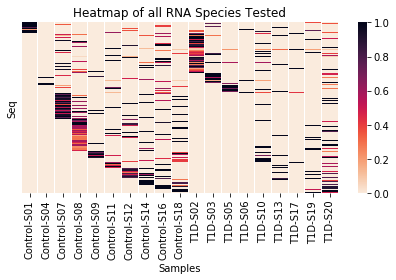

In [63]:
cmap = sns.cm.rocket_r
ax2 = sns.heatmap(norm_data,yticklabels=False,cmap=cmap)
plt.xlabel("Samples")
plt.ylabel("Seq")
plt.title("Heatmap of all RNA Species Tested")
plt.tight_layout()
plt.savefig("RNA_Tested_Heatmap");

In [64]:
sig_seq = sig_data.index

In [66]:
sig_count_data = countdata.loc[sig_seq]

In [67]:
norm_sig_data = sig_count_data.div(total_counts, axis="columns")

In [69]:
#Max normalize for each row for visualization.
norm_sig_data = norm_sig_data.div(norm_sig_data.max(axis=1), axis=0) 

In [70]:
norm_sig_data = pd.DataFrame(norm_sig_data.values, index=norm_sig_data.index, columns=sample_index).sort_index(axis=1)

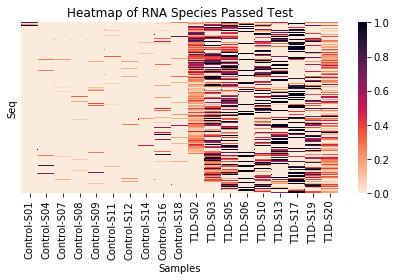

In [73]:
cmap = sns.cm.rocket_r
ax3 = sns.heatmap(norm_sig_data,yticklabels=False,cmap=cmap)
plt.xlabel("Samples")
plt.ylabel("Seq")
plt.title("Heatmap of RNA Species Passed Test")
plt.tight_layout()
plt.savefig("RNA_Passed_Heatmap");

## Annotations

In [76]:
samples = data.columns
bam_data = [pd.read_csv(f"{s}_data.csv", index_col=0).set_index(["seq","strand"]) for s in samples]

In [77]:
bam_data[0].head(5)

,,count,ref_id,start,end,len,mapflag
seq,strand,,,,,,
GGACCGGCGCAAGACGGACCAGAGCGAAAGCATTTGCCAAGAATGTT,+,6757,chr21,8210599,8210646,47,True
CATGACCCGCCGGGCAGCTTCCGGGAAACCAAAGTCTTTGGGTTCCG,+,4475,chr21,8210747,8210794,47,True
GCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTAG,+,3454,chr21,8213888,8213935,47,True
CGCGACCTCAGATCAGACGTGGCGACCCGCTGAATTTAAGCATATTA,+,2859,chr21,8213887,8213934,47,True
CTTTGGGTTCCGGGGGGAGTATGGTTGCAAAGCTG,+,2847,chr21,8210782,8210817,35,True


In [86]:
def addBed_update(row):
    bed = []
    for s in range(19):
        if row[s] > 0:
            sample = bam_data[s].loc[row.name]
            ref_id = sample["ref_id"]
            start = sample["start"]
            end = sample["end"]
            bed = f"{ref_id}\t{start}\t{end}"   
            return bed

In [87]:
bed_data = sig_data.apply(addBed_update, axis=1)

In [92]:
bed_data.to_csv("sig_rna.bed",index=False, header=False)

In [101]:
#All RNA species that passed our filters and test are sequence unique (no sequence with both - and + strand present)
len(bed_data.index.get_level_values(0).unique())

2628

In [104]:
%%bash
#Intersect with known smRNA
bedtools intersect -a sig_rna.bed -b /avicenna/genomes/hg38/hg38_smRNAs.bed -loj > T1D_smRNA_intersect.bed 

In [149]:
smRNA_intersect = pd.read_csv("T1D_smRNA_intersect.bed", header=None, sep="\t")

In [158]:
smRNA_intersect = smRNA_intersect[smRNA_intersect[3] != "."]

In [161]:
smRNA_intersect.head(10)

,0,1,2,3,4,5,6,7,8
19,chr11,62853907,62853948,chr11,62853903,62853968,U29,1,-
21,chr11,93732364,93732411,chr11,93732360,93732499,ACA8,1,-
24,chr19,49490615,49490662,chr19,49490616,49490699,U33,1,+
25,chr19,49490907,49490954,chr19,49490906,49490972,U34,1,+
40,chr1,28508721,28508762,chr1,28508557,28508762,U17b,1,+
43,chr1,173866665,173866712,chr1,173866634,173866714,U76,1,-
44,chr1,155920000,155920047,chr1,155919908,155920042,ACA42,1,-
61,chr15,66502043,66502090,chr15,66502021,66502091,U18B,1,-
63,chr19,49489966,49490013,chr19,49489967,49490044,U32A,1,+
64,chr19,49489967,49490014,chr19,49489967,49490044,U32A,1,+


In [170]:
smRNA_intersect.shape

(247, 9)

In [105]:
%%bash
#Intersect with known genes
 bedtools intersect -a sig_rna.bed -b /avicenna/genomes/hg38/gencode.v28.annotation.gff3.gz -loj > T1D_genes_intersect.bed 

In [162]:
genes_intersect = pd.read_csv("T1D_genes_intersect.bed", header=None, sep="\t")

In [163]:
genes_intersect = genes_intersect[genes_intersect[3] != "."]

In [167]:
genes_intersect.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
2,chr5,126420032,126420054,chr5,HAVANA,transcript,126371313,126483549,.,+,.,ID=ENST00000506445.5;Parent=ENSG00000155324.9;...
3,chr5,126420032,126420054,chr5,HAVANA,gene,126360132,126496494,.,+,.,ID=ENSG00000155324.9;gene_id=ENSG00000155324.9...
4,chr5,126420032,126420054,chr5,HAVANA,transcript,126360132,126493608,.,+,.,ID=ENST00000513040.5;Parent=ENSG00000155324.9;...
5,chr2,239092881,239092922,chr2,HAVANA,transcript,239080918,239108053,.,-,.,ID=ENST00000487617.5;Parent=ENSG00000068024.16...
6,chr2,239092881,239092922,chr2,HAVANA,transcript,239091144,239102841,.,-,.,ID=ENST00000495497.1;Parent=ENSG00000068024.16...
7,chr2,239092881,239092922,chr2,HAVANA,transcript,239089676,239298639,.,-,.,ID=ENST00000463007.5;Parent=ENSG00000068024.16...
8,chr2,239092881,239092922,chr2,HAVANA,gene,239048168,239401654,.,-,.,ID=ENSG00000068024.16;gene_id=ENSG00000068024....
9,chr2,239092881,239092922,chr2,HAVANA,transcript,239048168,239400949,.,-,.,ID=ENST00000345617.7;Parent=ENSG00000068024.16...
10,chr2,239092881,239092922,chr2,ENSEMBL,transcript,239048169,239400949,.,-,.,ID=ENST00000543185.5;Parent=ENSG00000068024.16...
12,chr21,8211327,8211350,chr21,HAVANA,gene,8197620,8227646,.,+,.,ID=ENSG00000278996.1;gene_id=ENSG00000278996.1...


In [168]:
genes_intersect.shape

(12113, 12)

Of the 2628 RNA species that passed our Fisher Test filter, there were 247 overlaps with known smRNAs and 12113 overlaps with known genes.